<a href="https://colab.research.google.com/github/eojo91/ds2_2023_summer_ml_project1/blob/Kyungheui.Cho/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 4일 (금) 자정
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: 10%


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [ ]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

In [ ]:
from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

### 2. 데이터
#### 2.1. 데이터 로드

In [ ]:
def load_data(local=False):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups

In [ ]:
X, Y, groups = load_data(local=False)

print(X.shape, Y.shape, groups.shape)

(13940, 500, 3) (13940,) (13940,)


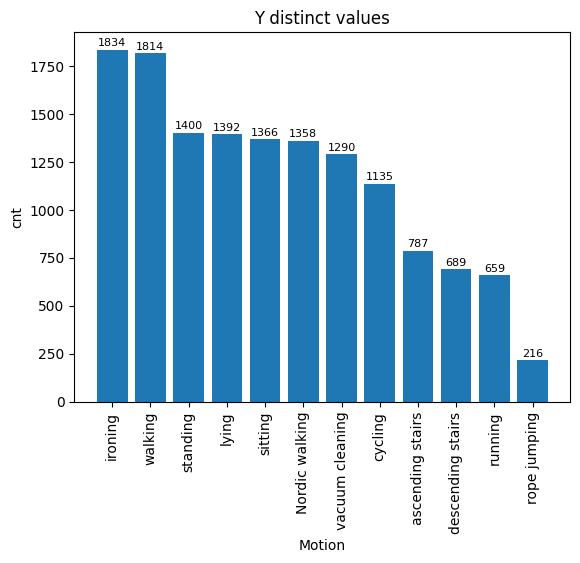

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# Y 배열에서 고유한 값들과 각 값들의 개수를 구하기
unique_values, value_counts = np.unique(Y, return_counts=True)

# 고유한 값들과 개수를 내림 차순으로 정렬하기
sorted_indices = np.argsort(value_counts)[::-1]
unique_values = unique_values[sorted_indices]
value_counts = value_counts[sorted_indices]

# 막대 그래프 그리기
plt.bar(unique_values, value_counts)

# 각 막대 위에 해당하는 y 값 표시
# plt.text 함수는 각 막대 위에 y 값을 표시합니다.
# unique_values[i]는 x 위치, v + 20는 y 위치(막대의 끝 위에 위치시키기 위해 20를 더했습니다),
# str(v)는 표시할 텍스트입니다. ha='center'는 텍스트를 가로 중앙에 맞춥니다.
for i, v in enumerate(value_counts):
    plt.text(unique_values[i], v + 20, str(v), ha='center', fontsize=8)

# 그래프에 제목과 축 레이블 추가
plt.title("Y distinct values")
plt.xlabel("Motion")
plt.ylabel("cnt")

# x축 레이블 세로로 표시하기
plt.xticks(rotation=90)

# 그래프 표시
plt.show()


#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

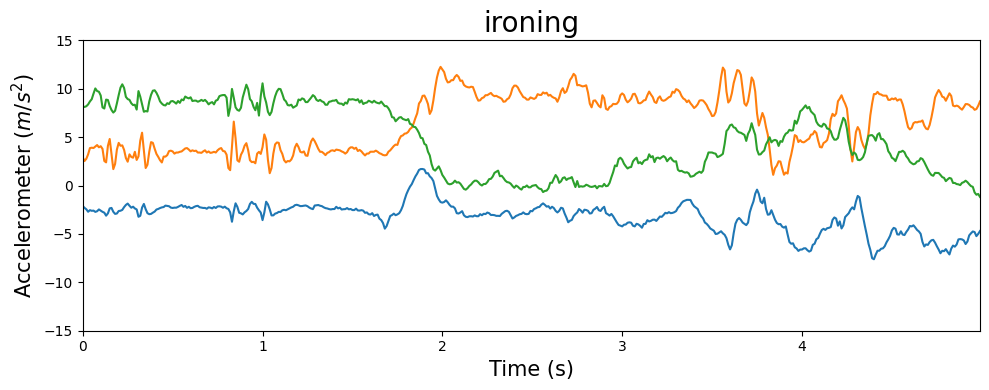

In [ ]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

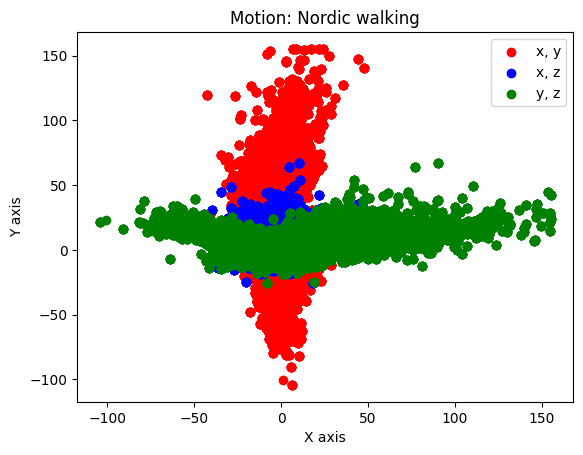

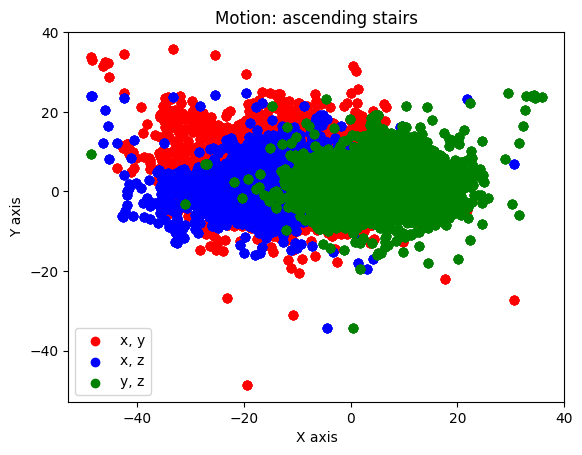

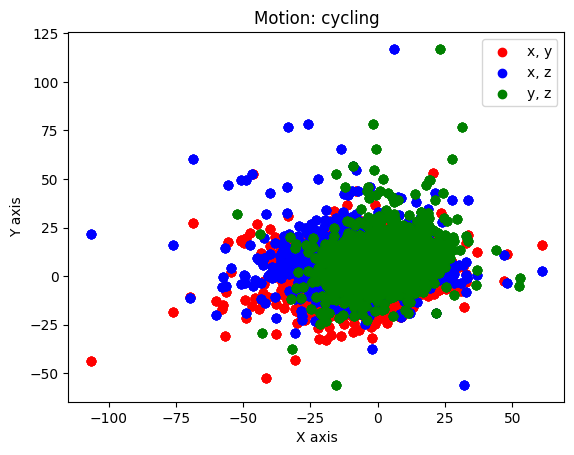

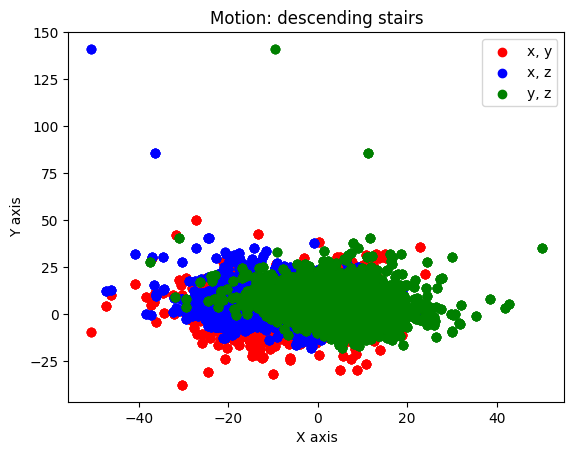

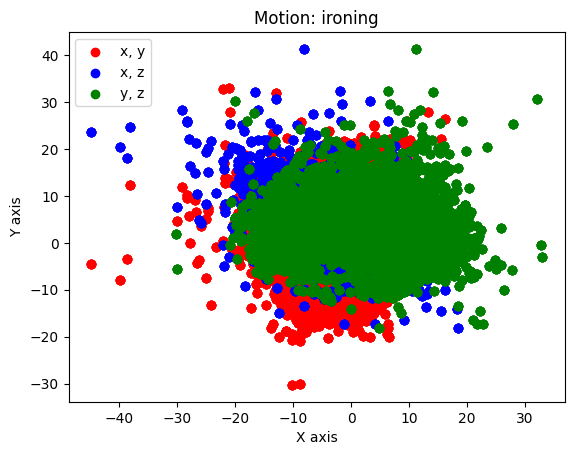

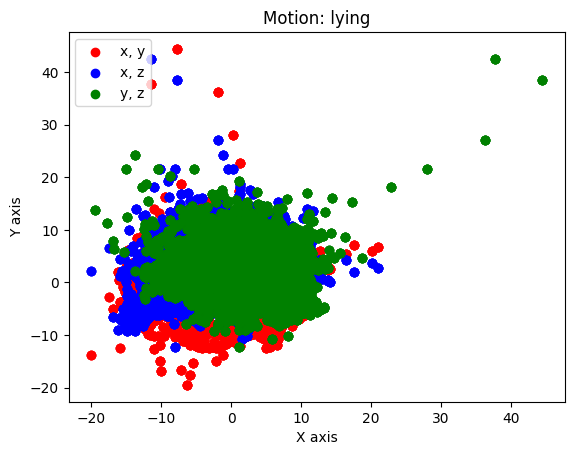

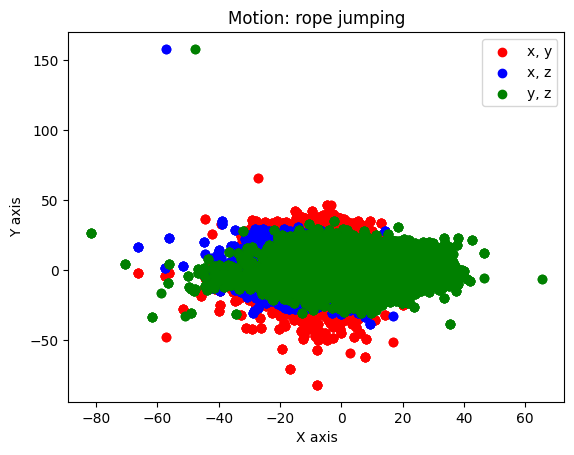

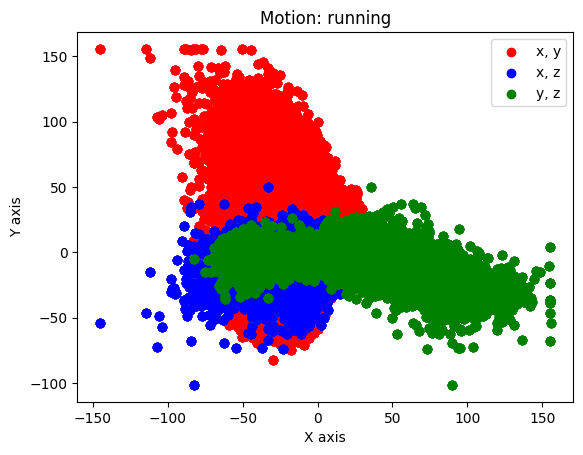

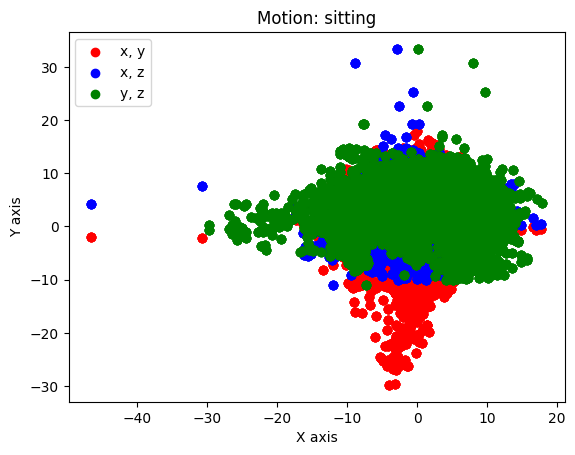

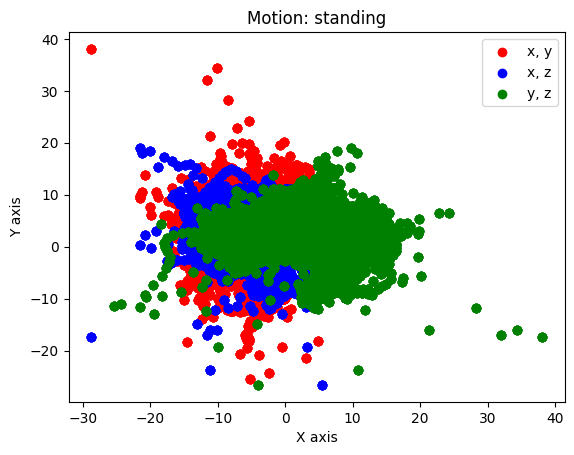

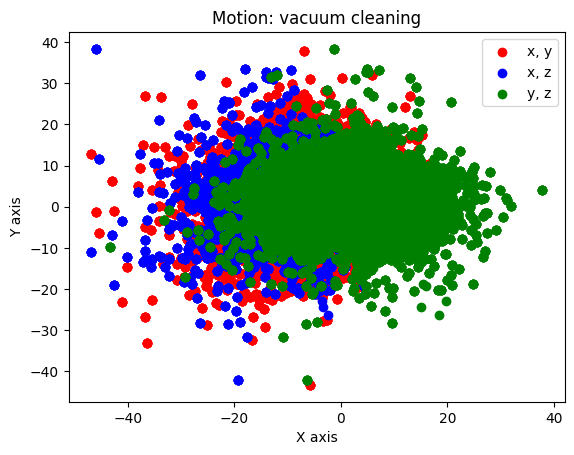

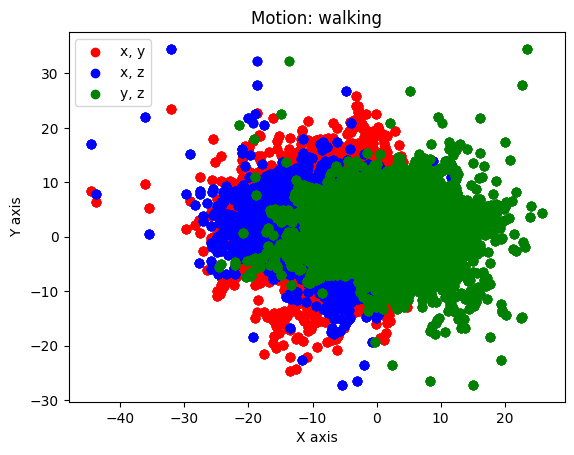

In [ ]:
# y 값의 종류를 확인합니다.
unique_y = np.unique(Y)

# 각 y 값의 종류별로 그래프를 그리고, 각 그래프에는 x 값의 x, y, z별 산포를 표현합니다.
for y_val in unique_y:
    # y 값이 해당 y_val인 데이터를 선택합니다.
    y_mask = (Y == y_val)
    x_data = X[y_mask]

    # 각 축의 데이터를 가져옵니다.
    x_axis = x_data[:, :, 0]  # x 축 데이터
    y_axis = x_data[:, :, 1]  # y 축 데이터
    z_axis = x_data[:, :, 2]  # z 축 데이터

    # 그래프를 그립니다.
    plt.figure()
    plt.scatter(x_axis, y_axis, c='r', label='x, y')  # x, y 축 데이터를 빨간색으로 표시
    plt.scatter(x_axis, z_axis, c='b', label='x, z')  # x, z 축 데이터를 파란색으로 표시
    plt.scatter(y_axis, z_axis, c='g', label='y, z')  # y, z 축 데이터를 초록색으로 표시
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f"Motion: {y_val}")
    plt.legend()
    plt.show()

['Nordic walking' 'ascending stairs' 'cycling' 'descending stairs'
 'ironing' 'lying' 'rope jumping' 'running' 'sitting' 'standing'
 'vacuum cleaning' 'walking']
[1358  787 1135  689 1834 1392  216  659 1366 1400 1290 1814]


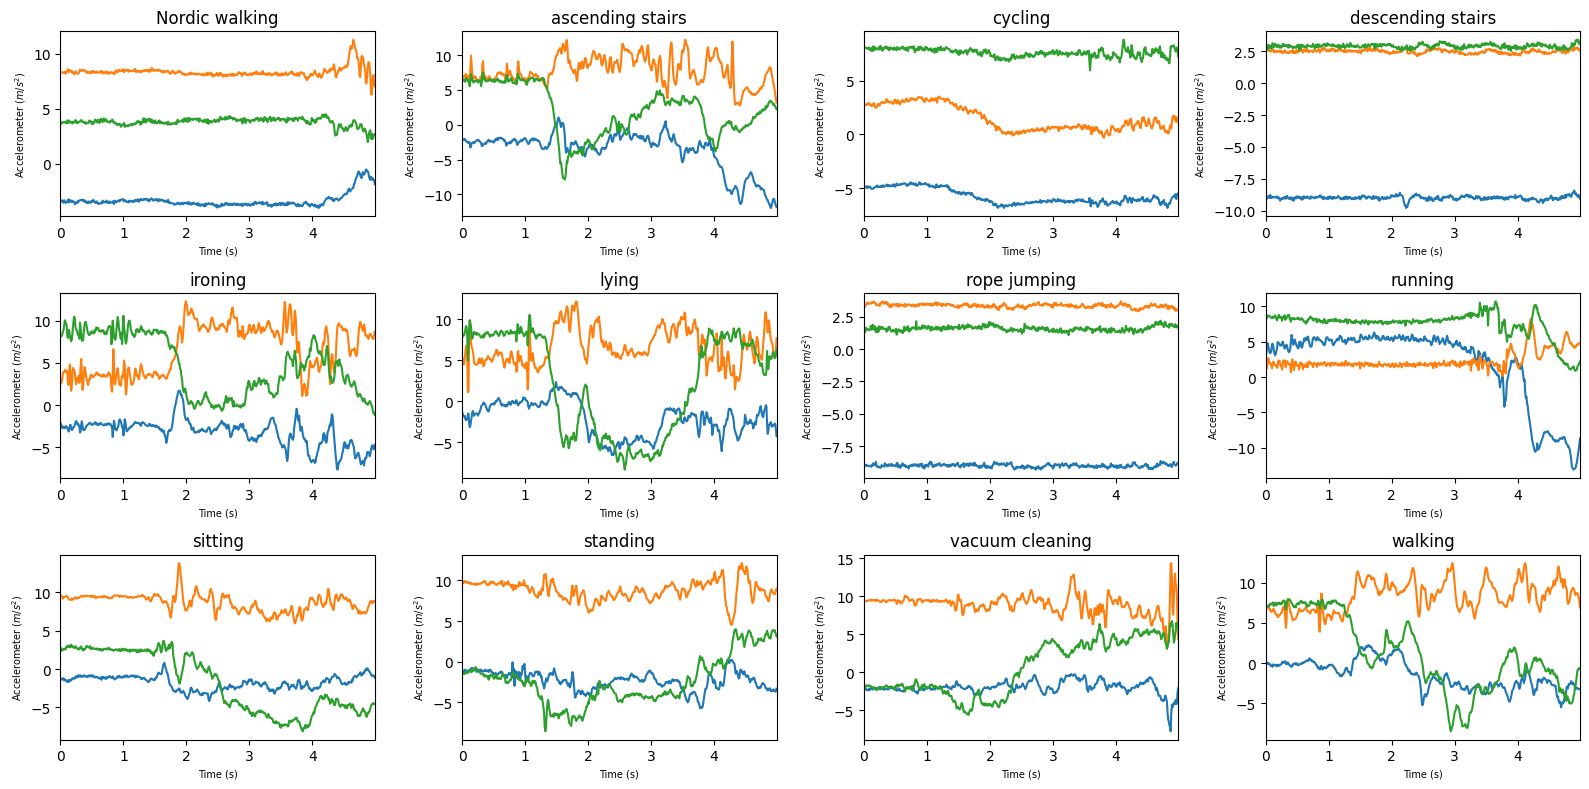

In [ ]:
y_name, y_first_index, y_counts = np.unique(Y, return_index=True, return_counts=True)
print(y_name)
print(y_counts)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(y_first_index)):
  idx = y_first_index[i]
  X_sample, Y_sample = X[idx], Y[idx]
  time_stamps = np.arange(0, len(X_sample)) / 100

  ax = axes[i // 4, i % 4]

  ax.plot(time_stamps, X_sample)

  ax.set_title(Y_sample, fontsize=12)
  ax.set_xlabel('Time (s)', fontsize=7)
  ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  ax.set_xlim(min(time_stamps), max(time_stamps))

  fig.tight_layout()
  fig.show()

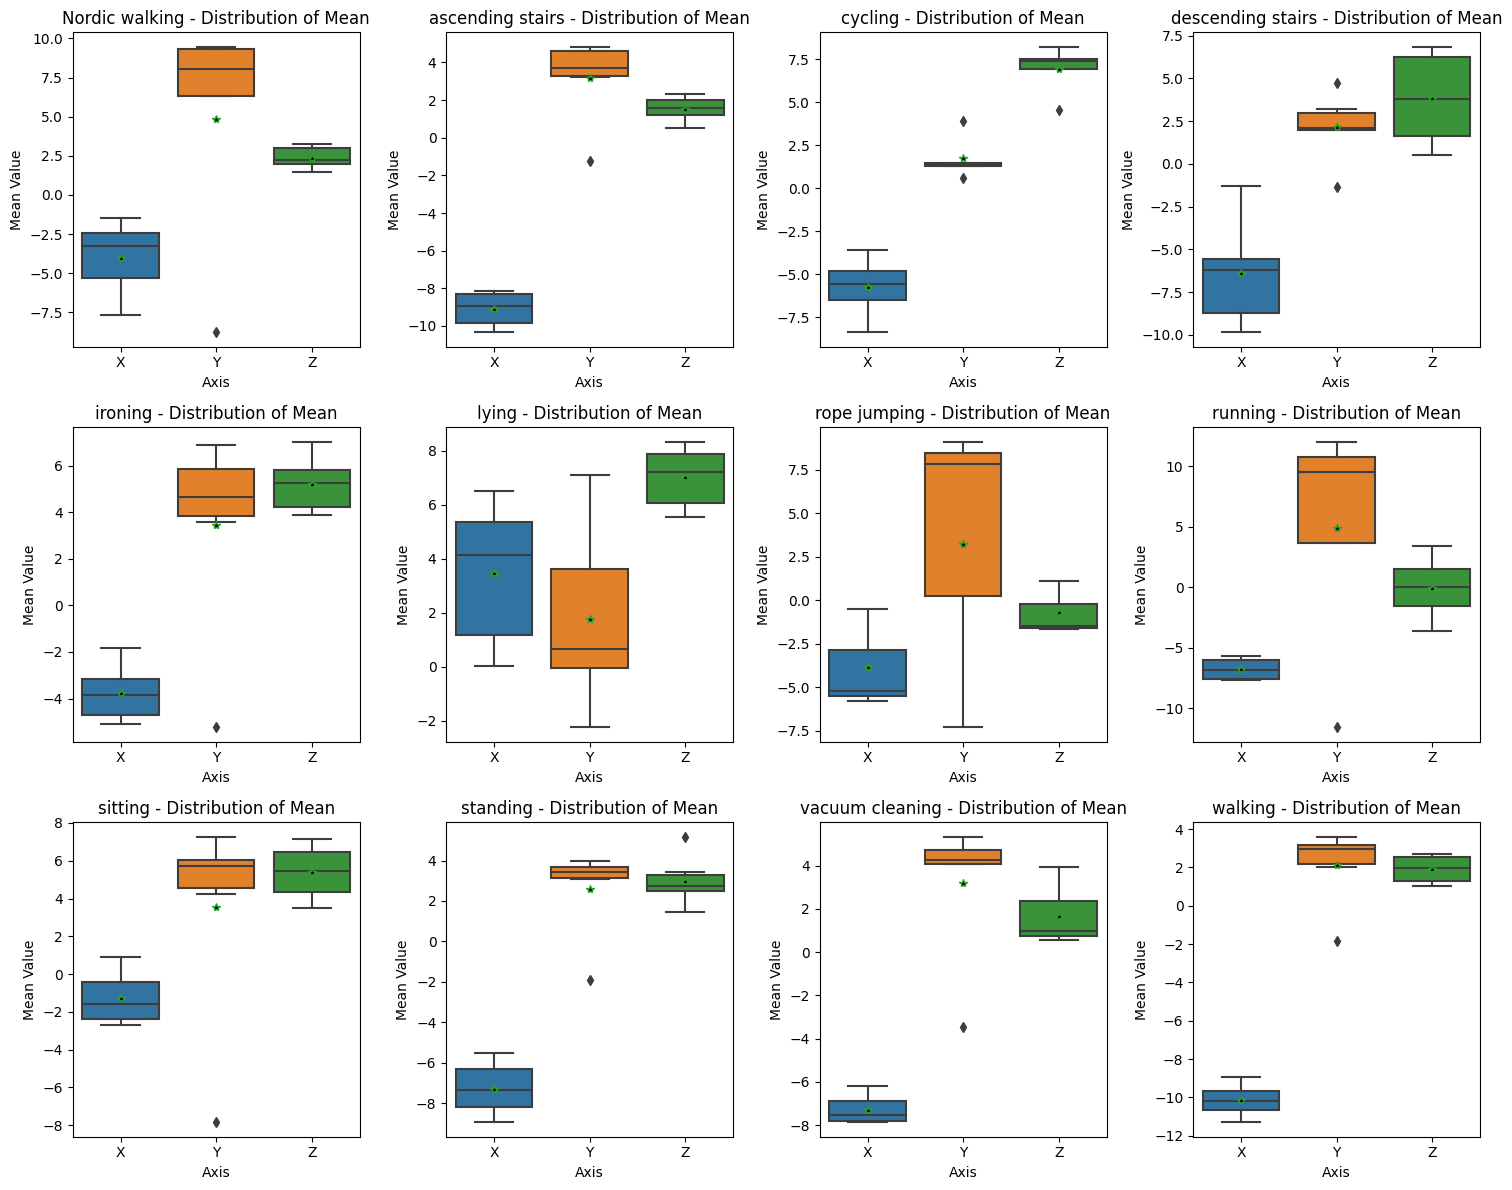

<Figure size 640x480 with 0 Axes>

In [ ]:
# 왠지 사용자별 모션에 따라 x, y, z 값의 range가 다를것 같아서.. 누군가는 빨리 달리고, 누군가는 줄넘기 할대 높게 뛰고 해서.. normalize가 필요하지 않을가 싶어서..
# 모션별로 사용자별 x, y, z 값의 평균을 저장할 리스트
motion_data_list = []

# 모션별로 사용자별 x, y, z 값의 평균 계산
for motion in unique_motions:
    motion_indices = np.where(Y == motion)[0]
    motion_subjects = groups[motion_indices]
    unique_subjects_in_motion = np.unique(motion_subjects)

    for subject in unique_subjects_in_motion:
        subject_indices = np.where(motion_subjects == subject)[0]
        x_mean = X[motion_indices[subject_indices], :, 0].mean()
        y_mean = X[motion_indices[subject_indices], :, 1].mean()
        z_mean = X[motion_indices[subject_indices], :, 2].mean()

        motion_data_list.append((motion, subject, 'X', x_mean))
        motion_data_list.append((motion, subject, 'Y', y_mean))
        motion_data_list.append((motion, subject, 'Z', z_mean))

# DataFrame으로 변환
motion_df = pd.DataFrame(motion_data_list, columns=['Motion', 'Subject', 'Axis', 'MeanValue'])

# 모션별로 그래프 그리기
plt.figure(figsize=(15, len(unique_motions))) # 세로 길이를 모션의 개수만큼 설정
for idx, motion in enumerate(unique_motions):
    plt.subplot(len(unique_motions) // 4, 4, idx + 1)
    sns.boxplot(x='Axis', y='MeanValue', data=motion_df[motion_df['Motion'] == motion],
                meanprops={"marker":"*", "markerfacecolor":"black"}, showmeans=True) # 평균값을 *로 표기
    plt.title(f'{motion} - Distribution of Mean')
    plt.xlabel('Axis')
    plt.ylabel('Mean Value')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


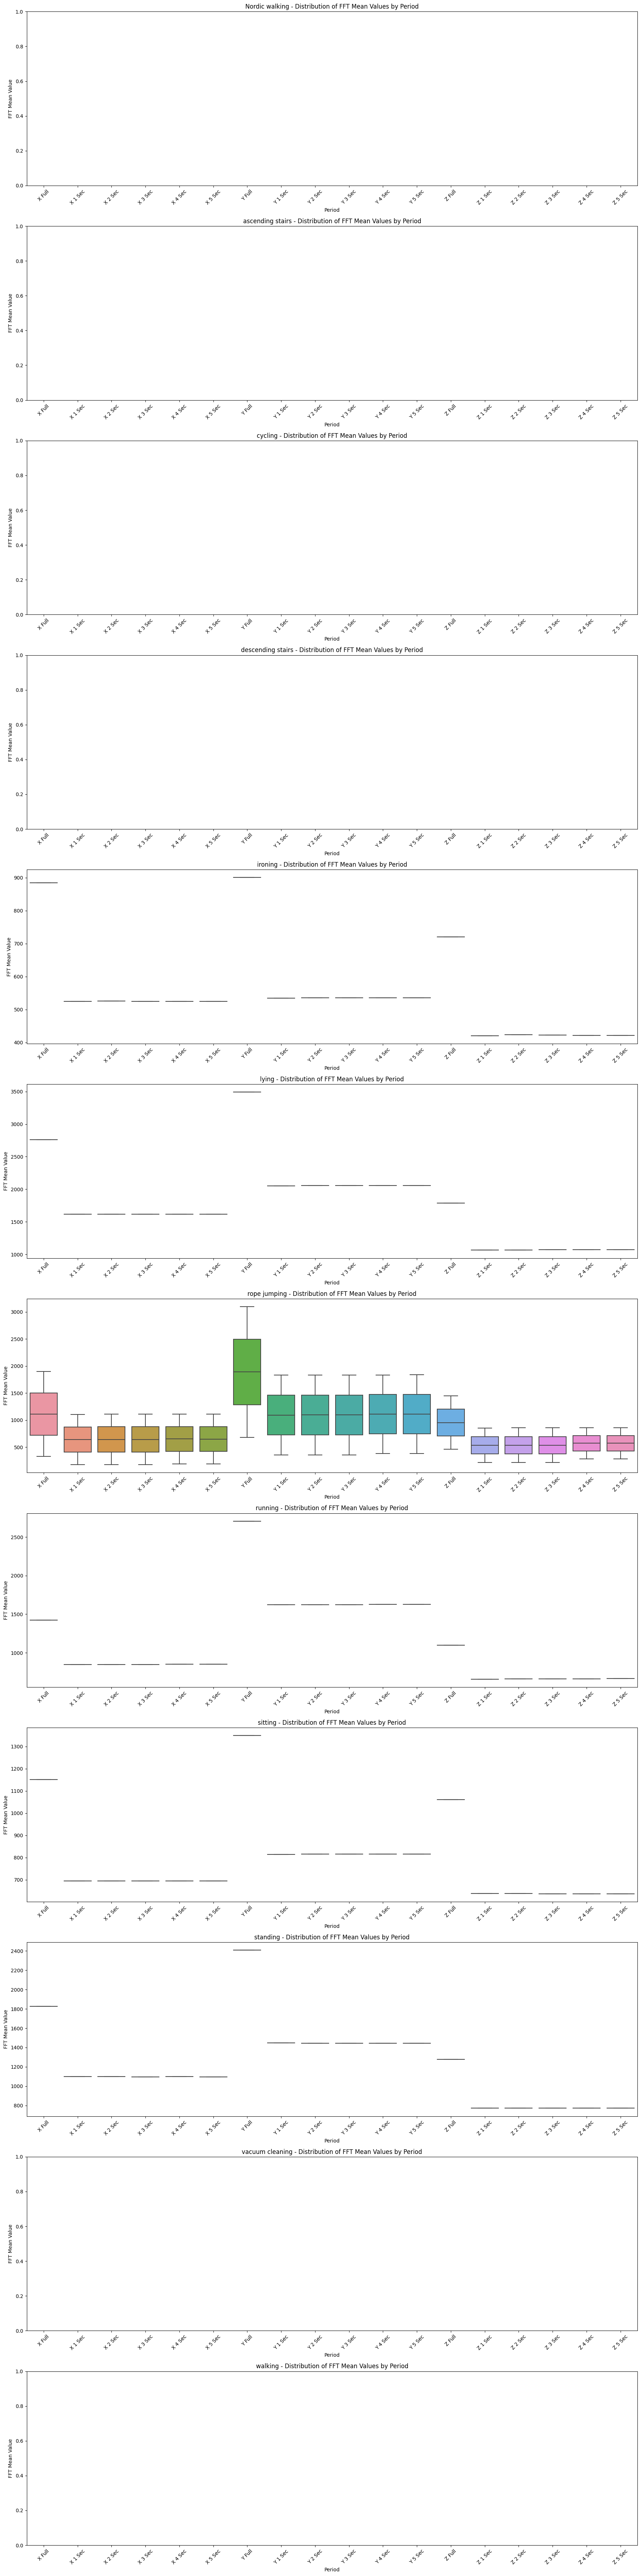

In [ ]:
# 사용자별 FFT 주기를 저장할 리스트
fft_data_list = []

# 사용자별로 x, y, z 값의 FFT 주기 계산
for subject in unique_subjects:
    subject_indices = np.where(groups == subject)[0]
    motion = Y[subject_indices][0]  # 해당 사용자의 모션
    for axis, axis_label in enumerate(['X', 'Y', 'Z']):
        # 전체 주기
        full_fft = np.abs(fft(X[subject_indices, :, axis].flatten()))

        # 1초, 2초, ..., 5초 주기
        segmented_ffts = [np.abs(fft(X[subject_indices, i*100:(i+1)*100, axis].flatten())) for i in range(5)]

        # 데이터 저장
        fft_data_list.append((subject, motion, axis_label, 'Full', full_fft.mean()))
        for i, segmented_fft in enumerate(segmented_ffts):
            fft_data_list.append((subject, motion, axis_label, f'{i+1} Sec', segmented_fft.mean()))

# DataFrame으로 변환
fft_df = pd.DataFrame(fft_data_list, columns=['Subject', 'Motion', 'Axis', 'Period', 'FFT_Mean'])

# x축 순서 정의
order = [f'{axis} {period}' for axis in ['X', 'Y', 'Z'] for period in ['Full', '1 Sec', '2 Sec', '3 Sec', '4 Sec', '5 Sec']]

# 모션별로 그래프 그리기
plt.figure(figsize=(18, len(unique_motions) * 6))
for idx, motion in enumerate(unique_motions):
    plt.subplot(len(unique_motions), 1, idx + 1)
    motion_data = fft_df[fft_df['Motion'] == motion].copy() # 복사본 사용
    motion_data['X_Period'] = motion_data['Axis'] + ' ' + motion_data['Period']
    sns.boxplot(x='X_Period', y='FFT_Mean', data=motion_data, order=order)
    plt.title(f'{motion} - Distribution of FFT Mean Values by Period')
    plt.xlabel('Period')
    plt.ylabel('FFT Mean Value')
    plt.xticks(rotation=45)  # x축 라벨 회전

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import numpy as np

# 특성을 저장할 리스트
features_list = []

# 사용자와 모션별로 특성 계산
for subject in unique_subjects:
    subject_indices = np.where(groups == subject)[0]
    motion = Y[subject_indices][0]  # 해당 사용자의 모션
    for axis, axis_label in enumerate(['X', 'Y', 'Z']):
        data = X[subject_indices, :, axis].flatten()

        # 특성 계산
        min_val = np.min(data)
        max_val = np.max(data)
        amplitude = max_val - min_val
        sum_val = np.sum(data)
        abs_sum = np.sum(np.abs(data))
        euclidean_norm = np.linalg.norm(data)
        mean_val = np.mean(data)
        abs_mean = np.mean(np.abs(data))
        mean_abs_dev = np.mean(np.abs(data - mean_val))
        variance_val = np.var(data)
        std_dev = np.std(data)
        zero_crossings = ((data[:-1] * data[1:]) < 0).sum()
        auto_correlations = np.correlate(data, data, mode='full')
        skewness_val = skew(data)
        kurtosis_val = kurtosis(data)
        percentiles_val = np.percentile(data, [25, 50, 75])
        power_val = np.sum(data**2) / len(data)
        rms = np.sqrt(np.mean(data**2))
        cross_correlation = np.correlate(data, data)
        energy_val = np.sum(data**2)
        entropy_val = -np.sum(data * np.log2(data))
        spectral_centroid = np.sum(np.fft.fftfreq(len(data)) * np.abs(fft(data))) / np.sum(np.abs(fft(data)))
        median_val = np.median(data)
        dominant_frequency = np.argmax(np.abs(fft(data)))

        # 특성 저장
        features_list.append((subject, motion, axis_label, min_val, max_val, amplitude, sum_val, abs_sum,
                             euclidean_norm, mean_val, abs_mean, mean_abs_dev, variance_val, std_dev,
                             zero_crossings, auto_correlations, skewness_val, kurtosis_val, percentiles_val,
                             power_val, rms, cross_correlation, energy_val, entropy_val, power_val,
                             spectral_centroid, mean_val, median_val, std_dev, dominant_frequency))

# DataFrame으로 변환
features_df = pd.DataFrame(features_list, columns=['Subject', 'Motion', 'Axis', 'Min', 'Max', 'Amplitude', 'Sum',
                                                   'Absolute Sum', 'Euclidean Norm', 'Mean', 'Absolute Mean',
                                                   'Mean Absolute Deviation', 'Variance', 'Standard Deviation',
                                                   'Zero Crossings', 'Auto-Correlations', 'Skewness', 'Kurtosis',
                                                   'Percentiles', 'Power', 'Root Mean Square', 'Cross-Correlation',
                                                   'Energy', 'Entropy', 'Power', 'Spectral Centroid', 'Mean',
                                                   'Median', 'Standard Deviation', 'Dominant Frequency'])


<ipython-input-18-5cbf143324e0>:36: RuntimeWarning: invalid value encountered in log2
  entropy_val = -np.sum(data * np.log2(data))


### 4. 구현

In [ ]:
############################################################
# Implement your own LRClassifier in this cell

import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis

from tqdm import tqdm
from numpy.fft import fft

def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    features = []

    for axis in range(3): # x, y, z 축
        data = X_sample[:, axis]

        # 특성 계산
        min_val = np.min(data)
        max_val = np.max(data)
        amplitude = max_val - min_val
        sum_val = np.sum(data)
        abs_sum = np.sum(np.abs(data))
        euclidean_norm = np.linalg.norm(data)
        mean_val = np.mean(data)
        abs_mean = np.mean(np.abs(data))
        mean_abs_dev = np.mean(np.abs(data - mean_val))
        variance_val = np.var(data)
        std_dev = np.std(data)
        zero_crossings = ((data[:-1] * data[1:]) < 0).sum()
        fdata = fft(data)
        auto_correlations = np.real(fft(fdata * np.conj(fdata)))
        skewness_val = skew(data)
        kurtosis_val = kurtosis(data)
        percentiles_val = np.percentile(data, [25, 50, 75])
        power_val = np.sum(data**2) / len(data)
        rms = np.sqrt(np.mean(data**2))
        cross_correlation = np.correlate(data, data)
        energy_val = np.sum(data**2)
        entropy_val = -np.sum(data * np.log2(data))
        spectral_centroid = np.sum(np.fft.fftfreq(len(data)) * np.abs(fft(data))) / np.sum(np.abs(fft(data)))
        median_val = np.median(data)
        dominant_frequency = np.argmax(np.abs(fft(data)))

        # 특성 저장
        features.extend([min_val, max_val, amplitude, sum_val, abs_sum, euclidean_norm, mean_val, abs_mean,
                         mean_abs_dev, variance_val, std_dev, zero_crossings, skewness_val, kurtosis_val,
                         power_val, rms, energy_val, entropy_val, spectral_centroid, median_val, dominant_frequency])

    return np.hstack(features)



def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])



# Logistic Regression Classifier
LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(max_iter=1000)),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))


In [ ]:
# 기본 통계값 및 왜도, 첨도 계산
    for axis_data in [x, y, z]:
        features.append(np.mean(axis_data))
        features.append(np.std(axis_data))
        features.append(np.min(axis_data))
        features.append(np.max(axis_data))
        features.append(np.median(axis_data))
        features.append(skew(axis_data)) # 왜도
        features.append(kurtosis(axis_data)) # 첨도



In [ ]:
  # Calculate correlation coefficients
    correlation_xy = np.corrcoef(X_sample[:, 0], X_sample[:, 1])[0, 1]
    correlation_yz = np.corrcoef(X_sample[:, 1], X_sample[:, 2])[0, 1]
    correlation_zx = np.corrcoef(X_sample[:, 2], X_sample[:, 0])[0, 1]

    # Calculate absolute differences and their mean
    abs_diff_xy = np.abs(X_sample[:, 0] - X_sample[:, 1])
    abs_diff_yz = np.abs(X_sample[:, 1] - X_sample[:, 2])
    abs_diff_zx = np.abs(X_sample[:, 2] - X_sample[:, 0])
    mean_abs_diff_xy = np.mean(abs_diff_xy)
    mean_abs_diff_yz = np.mean(abs_diff_yz)
    mean_abs_diff_zx = np.mean(abs_diff_zx)

    # Calculate spread of absolute differences (variance)
    spread_abs_diff_xy = np.var(abs_diff_xy)
    spread_abs_diff_yz = np.var(abs_diff_yz)
    spread_abs_diff_zx = np.var(abs_diff_zx)

    dominant_frequencies = np.argmax(X_fft, axis=0)

    # 주기성 특징 추출
    periodic_jumps = np.abs(X_sample[1:] - X_sample[:-1])  # 주기적인 점프
    periodic_slopes = np.abs((X_sample[1:] - X_sample[:-1]) / X_sample[:-1])  # 주기적인 기울기

    # Calculate differences with proper indexing for the division
    diff_X = X_sample[1:] - X_sample[:-1]
    diff_X_prev = X_sample[:-1]  # Modify this line to keep the same size
    periodic_slope_changes = np.abs(diff_X / diff_X_prev)  # 주기적인 기울기의 변화

    # 시계열 특성 추출
    rolling_mean = np.mean(X_sample, axis=1)  # 이동평균
    rolling_std = np.std(X_sample, axis=1)  # 이동표준편차

### 5. Cross-validation with subjects

In [ ]:
X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))